# Лабораторная работа № 7
Решить краевую задачу для дифференциального уравнения эллиптического типа. Аппроксимацию уравнения произвести с использованием центрально-разностной схемы. Для решения дискретного аналога применить следующие методы: метод простых итераций (метод Либмана), метод Зейделя, метод простых итераций с верхней релаксацией. Вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением $U(x,y)$. Исследовать зависимость погрешности от сеточных параметров $h_x, h_y$.

### Вариант №5
**_Уравнение:_**
$$\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} =-u,$$

**_Граничные условия:_**
$$u_x(0,y) = cos(y),$$
$$u_x(1, y)-u(1,y)=0,$$
$$u(x, 0) = x,$$
$$u(x, \frac{\pi}{2}) = 0$$

**_Аналитическое решение:_**
$$U(x,t)=xcos(y)$$

## Решение
**Импорты:**

In [1]:
import numpy as np
import scipy.interpolate
from copy import deepcopy
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 10]

**Параметры:**

In [2]:
# границы
lx = 1
ly = np.pi / 2
# точность итерационного процесса
eps = 1e-05
# разбиение
Nx = 15
Ny = 15
# параметр релаксации
teta = 1.5
# шаги
hx = lx/Nx
hy = ly/Ny

**Граничные условия и аналитическое решение**

In [3]:
def phi1(y):
    return np.cos(y)
def phi2():
    return 0
def phi3(x):
    return x
def phi4(x):
    return 0
def analytic_solution(x, y):
    return x * np.cos(y)

### Вспомогательные функции
**Вычисление ошибки (через max):**

In [4]:
def norm(v1, v2):
    return np.amax(np.abs(v1 - v2))

def find_error(grid):
    u_correct = np.array([[analytic_solution(i*hx,j *hy) for j in range(Ny+1)] for i in range(Nx+1)])
    return norm(u_correct, grid)

**Построение графика:**

In [5]:
def view_mode(grid):
    
    y_array = np.array([i*hy for i in range(Ny+1)])

    fig, ax = plt.subplots()

    x = [int(Nx * 0.05), int(Nx * 0.1), int(Nx * 0.25)]
    colors = ['green', 'blue', 'red']

    for i in range(len(x)):
        u_correct = analytic_solution(x[i]*hx, y_array)
        u_calculated = grid[x[i]]
        ax.plot(y_array, u_correct, color='black')
        ax.plot(y_array, u_calculated, color=colors[i], linestyle = '--', label='x=%s'%round(x[i]*hx, 2))
        
    ax.set_xlabel('y')
    ax.set_ylabel('U(x, y)')
    ax.grid()
    ax.legend()

### Метод простых итераций (Либмана)

In [6]:
def Liebman_method():
    grid = np.zeros((Nx+1, Ny+1))
    
    # верхний и нижний слой
    for i in range(Nx + 1):
        grid[i][0] = phi3(i * hx)
        grid[i][Ny] = phi4(i * hx)

    # Итерационный процесс
    k = 0
    while True:
        grid_next = deepcopy(grid)
        for i in range(1, Nx):
            for j in range(1, Ny):
                grid_next[i][j] = 1/(2/hx**2+2/hy**2-1)*((grid[i-1][j]+grid[i+1][j])/hx**2+(grid[i][j-1]+grid[i][j+1])/hy**2)

        # Аппроксимация граничных условий 2-го и 3-го рода
        for j in range(Ny):
            grid_next[0][j] = grid_next[1][j]-hx*phi1(j*hy)
            grid_next[Nx][j] = (grid_next[Nx-1][j]+hx*phi2())/(1-hx)
        
        # Условие прекращения цикла
        if norm(grid, grid_next) < eps:
            break
        
        grid = deepcopy(grid_next)
        k += 1
        
    return grid, k

Кол-во итераций:  2231
Ошибка:  0.004042668824270512


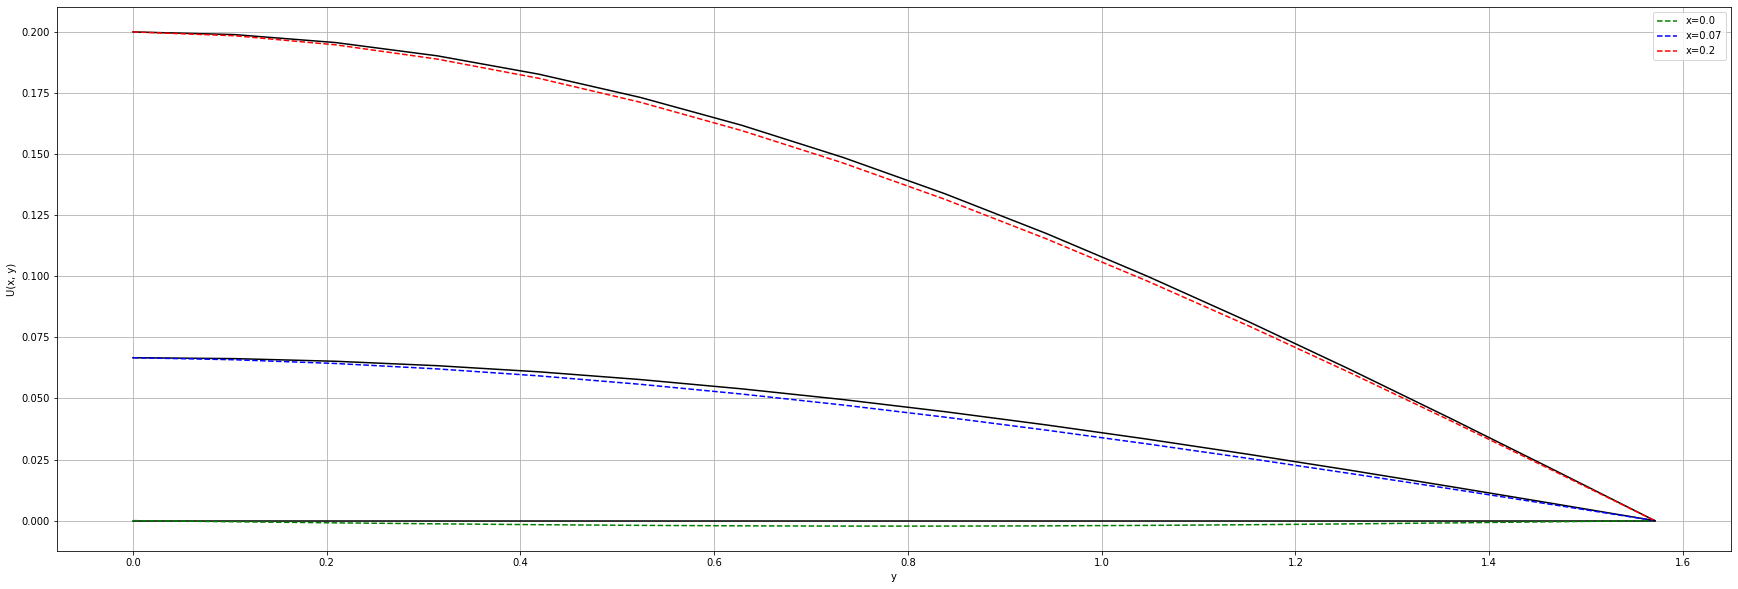

In [7]:
grid1, k = Liebman_method()
print('Кол-во итераций: ', k)
print('Ошибка: ', find_error(grid1))
view_mode(grid1)

---
### Метод Зейделя

In [8]:
def Seidel_method():
    grid = np.zeros((Nx+1, Ny+1))

    # Заполняем граничные условия 1-го рода
    for i in range(Nx + 1):
        grid[i][0] = phi3(i * hx)
        grid[i][Ny] = phi4(i * hx)

    # Итерационный процесс
    k = 0
    while True:
        grid_prev = deepcopy(grid)
        for i in range(1, Nx):
            for j in range(1, Ny):
                grid[i][j] = 1/(2/hx**2+2/hy**2 - 1)*((grid[i-1][j]+grid[i+1][j])/hx**2+(grid[i][j-1]+grid[i][j+1])/hy**2)

        # Аппроксимация граничных условий 2-го и 3-го рода
        for j in range(Ny):
            grid[0][j] = grid[1][j]-hx*phi1(j*hy)
            grid[Nx][j] = (grid[Nx-1][j]+hx*phi2())/(1-hx)
        
        # Условие прекращения цикла
        if norm(grid, grid_prev) < eps:
            break
        
        k += 1
        
    return grid, k

Кол-во итераций:  1338
Ошибка:  0.0019395587099627631


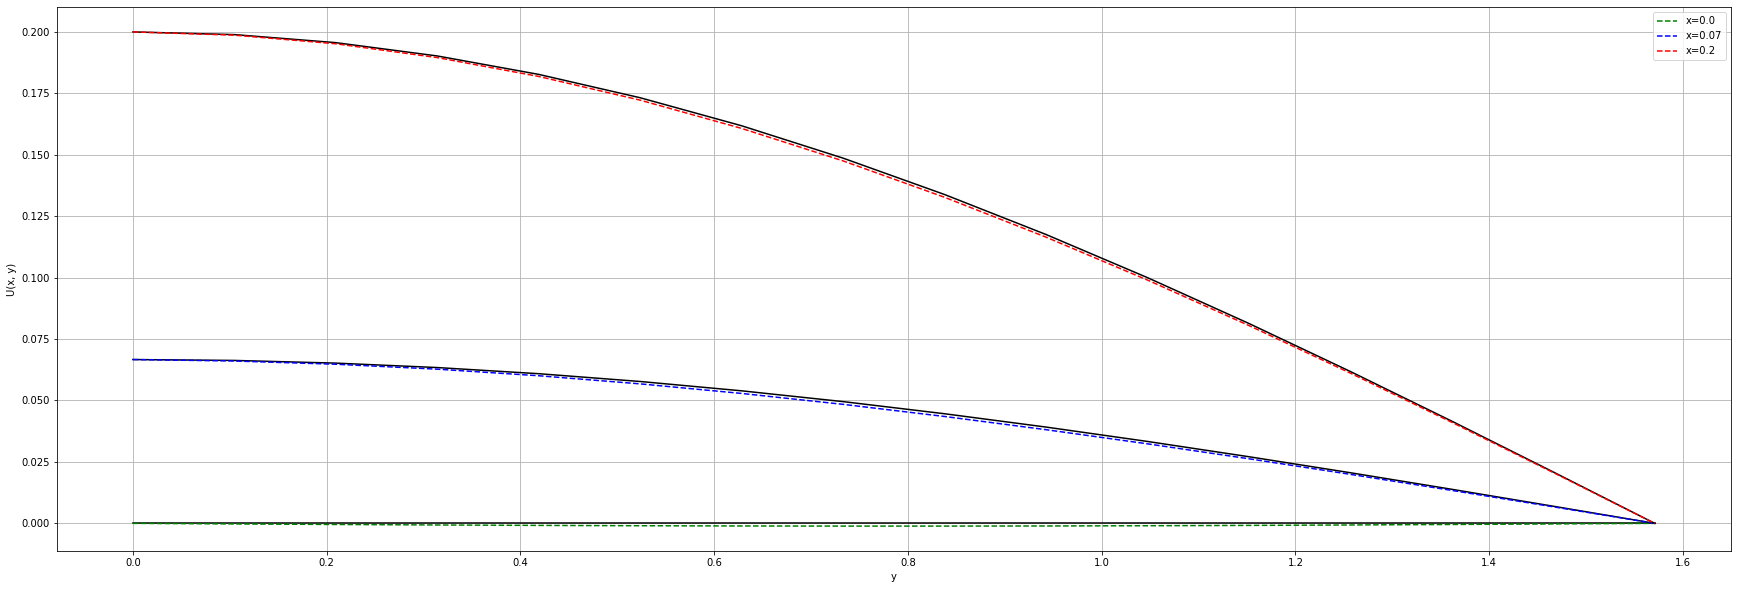

In [9]:
grid2, k = Seidel_method()
print('Кол-во итераций: ', k)
print('Ошибка: ', find_error(grid2))
view_mode(grid2)

---
### Метод верхней релаксации

In [10]:
def Relax_method():
    grid = np.zeros((Nx+1, Ny+1))

    # Заполняем граничные условия 1-го рода
    for i in range(Nx + 1):
        grid[i][0] = phi3(i * hx)
        grid[i][Ny] = phi4(i * hx)

    # Итерационный процесс Зейделя
    k = 0
    while True:
        grid_prev = deepcopy(grid)
        for i in range(1, Nx):
            for j in range(1, Ny):
                grid[i][j] = 1/(2/hx**2+2/hy**2 - 1)*((grid[i-1][j]+grid[i+1][j])/hx**2+(grid[i][j-1]+grid[i][j+1])/hy**2)

        # Аппроксимация граничных условий 2-го и 3-го рода
        for j in range(Ny):
            grid[0][j] = grid[1][j]-hx*phi1(j*hy)
            grid[Nx][j] = (grid[Nx-1][j]+hx*phi2())/(1-hx)
        
        # Релаксация
        grid = teta*grid+(1-teta)*grid_prev
        
        # Условие прекращения цикла
        if norm(grid, grid_prev) < eps:
            break
        
        k += 1
        
    return grid, k

Кол-во итераций:  956
Ошибка:  0.0011404943746653462


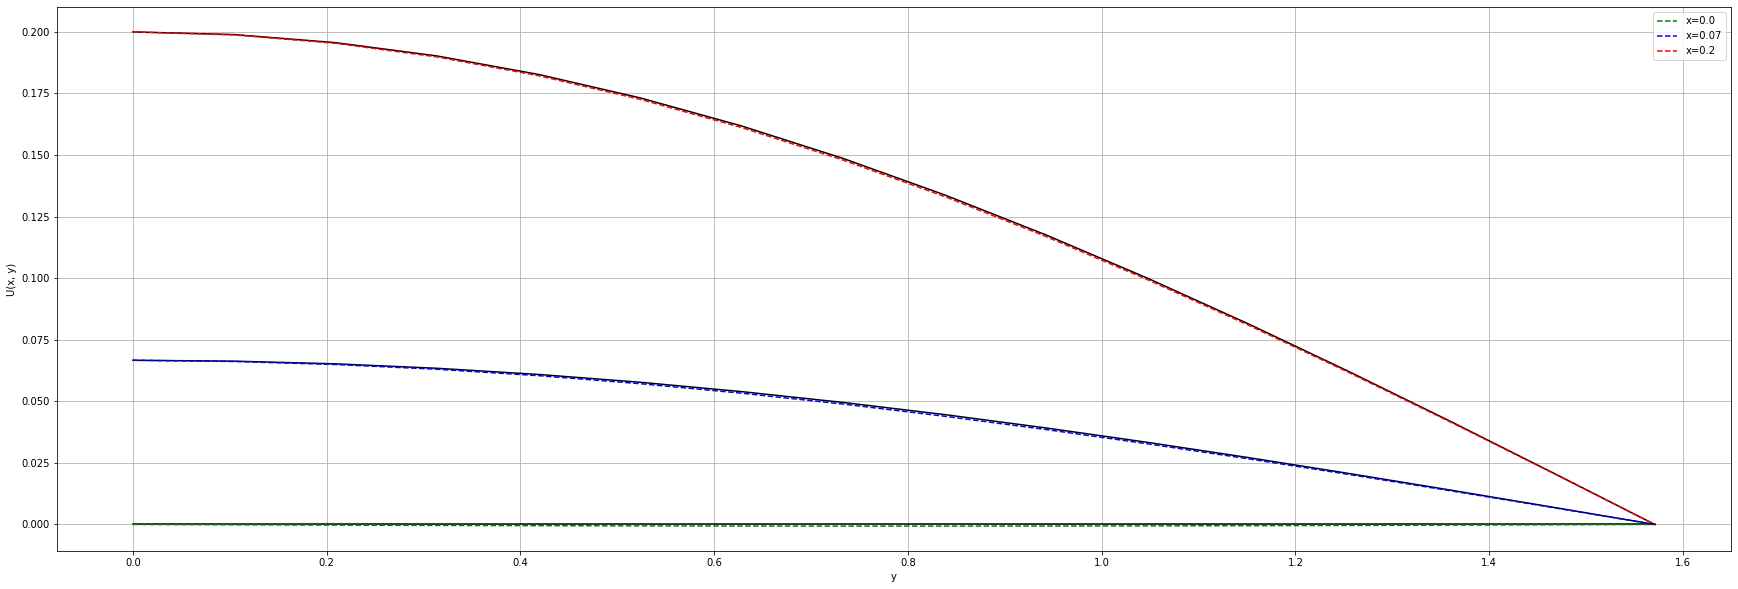

In [11]:
grid3, k = Relax_method()
print('Кол-во итераций: ', k)
print('Ошибка: ', find_error(grid3))
view_mode(grid3)